2023-07-30 16:58:49.660915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 16:58:50.275517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sudoku Environment avaible at gymnasium as 'Sudoku-v0'.


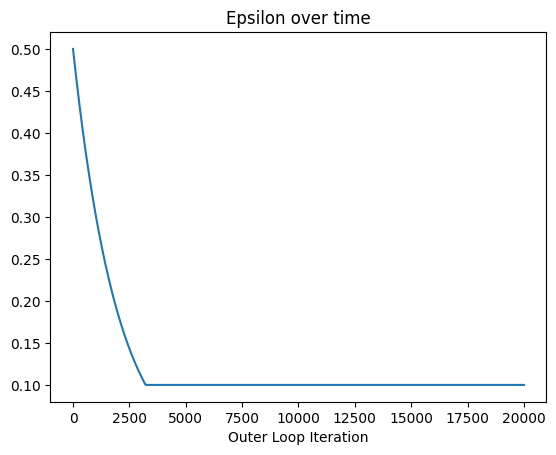

In [1]:
from deepsudoku import REPO_PATH, DIFFICULTIES
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
os.chdir(REPO_PATH)
import numpy as np
from deepsudoku.reinforcement_learning.dqn import *
import tqdm
import matplotlib.pyplot as plt
import pandas as pd

EXP_NAME = "initial_dqn"

GAMMA = 0.99
TAU = 0.01
BATCHSIZE = 256
N_BATCHES = 32
N_MULTI_ENVS = 64
EXPLORATION_RATE = 0.5
EPSILON_DECAY = 0.9995
LOSS_FUNC = tf.keras.losses.Huber()
ENV_KWARGS = {'difficulty': 'easy', 'factor_in_density': False, 'upper_bound_missing_digist': None}

N_NEW_SAMPLES = 200
N_SAMPLE_SETS = 100
N_BATCHES = 20

CHECKPOINT_FREQ = 20
LOG_FREQ = 20

x = np.arange(20000)
y = EXPLORATION_RATE * (EPSILON_DECAY ** x)
y = np.maximum(y, 0.1)

plt.plot(x,y)
plt.title("Epsilon over time")
plt.xlabel("Outer Loop Iteration")
plt.show()

In [2]:
TMP_SAVE_TO_PATH = f"ckpt/{EXP_NAME}ckps/ckpt"
TMP_LOG_PATH = f"logs/{EXP_NAME}/normal_logs/" + "{}.json"
TB_LOGS = f"logs/{EXP_NAME}/tb_lobs/"

os.makedirs(TMP_SAVE_TO_PATH.replace("/ckpt",""), exist_ok= True)
os.makedirs(TMP_LOG_PATH.replace("/{}.json",""), exist_ok= True)
os.makedirs(TB_LOGS, exist_ok= True)

In [3]:
model_inputs = tf.keras.Input((9,9,10))
x = model_inputs

x = tf.keras.layers.Conv2D(32,3, padding= "same", activation= "relu")(x)
x = tf.keras.layers.Conv2D(64,3, padding= "same", activation= "relu")(x)
x = tf.keras.layers.Conv2D(128,3, padding= "same", activation= "relu")(x)
x = tf.keras.layers.Conv2D(256,9, padding= "same", activation= "relu")(x)
x = tf.keras.layers.Conv2D(9,9, padding= "same", activation= "linear")(x)

dqn = tf.keras.Model(model_inputs,x)

target_dqn = tf.keras.models.clone_model(dqn)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

checkpoint = tf.train.Checkpoint(dqn = dqn, target_dqn = target_dqn, optimizer = optimizer)

writer = tf.summary.create_file_writer(TB_LOGS)

env_sampler = ENV_SAMPLER(dqn, N_MULTI_ENVS, ENV_KWARGS)
replay_buffer = SimpleReplayBuffer()

2023-07-30 16:58:51.661446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 16:58:51.683681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 16:58:51.683851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
for _ in tqdm.tqdm(range(N_SAMPLE_SETS), desc = "Fill Buffer initally"):

    new_samples = env_sampler.sample(N_NEW_SAMPLES, epsilon = EXPLORATION_RATE)
    replay_buffer.add_new_trajectory(new_samples)

Fill Buffer initally:   0%|          | 0/100 [00:00<?, ?it/s]2023-07-30 16:58:53.967162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-30 16:58:54.323275: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-30 16:58:54.323911: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-30 16:58:54.323934: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-07-30 16:58:54.324504: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-30 16:58:54.324582: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx com

In [6]:
outer_steps = 0


while True:
    

    outer_steps +=1
    EXPLORATION_RATE *= EPSILON_DECAY
    EXPLORATION_RATE = max(EXPLORATION_RATE, 0.1)
    
    ds = replay_buffer.generate_tf_dataset(N_BATCHES,BATCHSIZE)
    bar = ds # tqdm.tqdm(ds)
    
    losses = []

    for data in bar:

        loss = update_q_network(data, dqn, target_dqn, optimizer, GAMMA, LOSS_FUNC)
        
        losses.append(loss)
        mean_loss = float(np.mean(losses))
        # bar.set_description(f"Loss {mean_loss:.6f}")

    mean_loss = float(np.mean(losses))
    
    with writer.as_default():

        tf.summary.scalar("loss", mean_loss, step=outer_steps)
        tf.summary.scalar("epsilon", EXPLORATION_RATE, step=outer_steps)


    new_samples = env_sampler.sample(N_NEW_SAMPLES, epsilon= EXPLORATION_RATE)
    replay_buffer.add_new_trajectory(new_samples)

    replay_buffer.drop_first_trajectory()

    polyak_averaging(target_dqn, dqn, TAU)
    
    
    if outer_steps % LOG_FREQ == 0:
        
        print("Logging Model Metrics")
        
        results = env_sampler.measure_model_perforamnce()
        names = ["average_rewards", "average_termination"]

        for val, name in zip(results, names):

            with writer.as_default():

                tf.summary.scalar(name, val, step=outer_steps)

        results = pd.Series(results, names)
        
        results["average_loss"] = np.mean(losses)
        
        results.to_json(TMP_LOG_PATH.format(outer_steps))
        
        print(results)
        
        
    if outer_steps % CHECKPOINT_FREQ == 0:
        
        print("Saving Checkpoint")
        
        checkpoint.save(TMP_SAVE_TO_PATH)
        
    print(f"Finished with: {outer_steps}")

2023-07-30 17:00:49.429226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [5120]
	 [[{{node Placeholder/_3}}]]


Finished with: 1


2023-07-30 17:00:51.761150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 2


2023-07-30 17:00:53.876384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [5120,9,9]
	 [[{{node Placeholder/_0}}]]


Finished with: 3


2023-07-30 17:00:55.969743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [5120,9,9]
	 [[{{node Placeholder/_0}}]]


Finished with: 4


2023-07-30 17:00:58.058529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [5120]
	 [[{{node Placeholder/_3}}]]


Finished with: 5


2023-07-30 17:01:00.286856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [5120,9,9]
	 [[{{node Placeholder/_0}}]]


Finished with: 6


2023-07-30 17:01:02.533680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 7


2023-07-30 17:01:04.588059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 8


2023-07-30 17:01:06.805973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [5120]
	 [[{{node Placeholder/_3}}]]


Finished with: 9


2023-07-30 17:01:09.018148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype bool and shape [5120]
	 [[{{node Placeholder/_4}}]]


Finished with: 10


2023-07-30 17:01:11.184230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [5120,9,9]
	 [[{{node Placeholder/_1}}]]


Finished with: 11


2023-07-30 17:01:13.341863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 12


2023-07-30 17:01:15.559867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 13


2023-07-30 17:01:17.830418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [5120]
	 [[{{node Placeholder/_3}}]]


Finished with: 14


2023-07-30 17:01:20.092550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype bool and shape [5120]
	 [[{{node Placeholder/_4}}]]


Finished with: 15


2023-07-30 17:01:22.401259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 16


2023-07-30 17:01:24.768347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [5120]
	 [[{{node Placeholder/_3}}]]


Finished with: 17


2023-07-30 17:01:28.571112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [5120]
	 [[{{node Placeholder/_3}}]]


Finished with: 18


2023-07-30 17:01:30.779745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [5120,9,9]
	 [[{{node Placeholder/_0}}]]


Finished with: 19


2023-07-30 17:01:33.001648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype bool and shape [5120]
	 [[{{node Placeholder/_4}}]]


Logging Model Metrics
average_rewards       -1.000000
average_termination    0.500000
average_loss           0.049318
dtype: float64
Saving Checkpoint
Finished with: 20


2023-07-30 17:01:36.021999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype bool and shape [5120]
	 [[{{node Placeholder/_4}}]]


Finished with: 21


2023-07-30 17:01:38.186843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 22


2023-07-30 17:01:40.500687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 23


2023-07-30 17:01:42.867098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 24


2023-07-30 17:01:45.248723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 25


2023-07-30 17:01:47.538141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [5120]
	 [[{{node Placeholder/_3}}]]


Finished with: 26


2023-07-30 17:01:49.738756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype bool and shape [5120]
	 [[{{node Placeholder/_4}}]]


Finished with: 27


2023-07-30 17:01:51.904259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 28


2023-07-30 17:01:54.174745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 29


2023-07-30 17:01:56.388673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [5120,3]
	 [[{{node Placeholder/_2}}]]


Finished with: 30


2023-07-30 17:01:58.683955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [5120,9,9]
	 [[{{node Placeholder/_0}}]]
